<center><font size = "10"> Week 8 - Synapses<center>
<center><font size = "8">Tutorial 02: Tsodyks-Markram model<center>

<font size='3'><font color='blue'> In this tutorial you will use an AMPA and NMDA model of glutamate receptors augmented with a model of synapse dynamics, the Tsodyks-Markram model. 
    
<font size='3'><font color='blue'>You will learn how to implement the mathematical formulations into the MOD file and you will get a deeper understanding of this widely used formulation of synapse dynamics with a simplified and real morphologies.

## Some useful definitions and concepts:

- Short-term plasticity: short-term (order of 10s or 100s of milliseconds) changes in the efficacy of a synapse.

- Short-term facilitation: increase in synaptic efficacy. 

- Short-term depression: decreases in synaptic efficacy. 

One of the main mechanisms of short-term facilitation is transient increases in release probability of neurotransmitter-containing vesicles (due to increased presynaptic calcium concentration). Conversely, when many vesicles are released there will be fewer to release until the synapse has had a chance to replenish them, leading to short-term depression. 

This adds nonlinearities to the effects of individual synapses: for example, synapses which undergo short-term facilitation are much more effective at high firing rates than synapses which undergo short-term depression. The Tsodyks-Markram model captures these dynamics by modeling vesicle release.
    
*Slides: 24 - 27 of week 8 lecture

### Compile MOD files

In [1]:
!nrnivmodl

/Users/wesleymonteith/miniconda3/envs/biophysics/bin/nrnivmodl:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
/usr/bin/xcrun
/Users/wesleymonteith/code/nx-450-computational-neuroscience-biophysics/Tutorial_8-20241116
Mod files: "./NaTs2_t.mod" "./SK_E2.mod" "./SKv3_1.mod" "./SimpleAMPA_NMDA.mod" "./TsodyksMarkram_AMPA_NMDA.mod" "./vecevent.mod"

 -> Compiling mod_func.cpp
 => LINKING shared library ./libnrnmech.dylib
Successfully created x86_64/special


### Load the modules and hoc files that will be used

In [2]:
import neuron
from neuron import h
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Load external files & initialize
neuron.h.load_file("stdrun.hoc")
neuron.h.stdinit()

--No graphics will be displayed.


0.0

## 1. A simple neuron to host your synapse

<font size='3'>Following the previous tutorial, we will create a single compartment soma neuron to host the synapse.

In [3]:
# Define cell shape
soma = neuron.h.Section()
soma.L = 40
soma.diam = 40
soma.insert("pas")

__nrnsec_0x7fe729b98000

In [4]:
# Configure the passive biophysics
for sec in h.allsec():
    sec.Ra = 100
    sec.cm = 1

<font size='3'>Create the synapse at the center of the soma compartment

In [5]:
synapse = h.TsodyksMarkram_AMPA_NMDA(soma(0.5))

### Define the stimulus:

<font size='3'> 8 spikes at 20Hz + 1 spike 500 ms later

In [6]:
stimulator = h.VecStim()
spike_times = [100.0, 150.0, 200.0, 250.0, 300.0, 350.0, 400.0, 450.0, 950.0]
spikes_vector = h.Vector(spike_times)
stimulator.play(spikes_vector)

connection = h.NetCon(stimulator, synapse)
connection.weight[0] = 1.0  # In units of [nS] due to the gmax scaling factor in our .mod file

### Create a recorder for the synaptic conductance, current, the soma voltage, and the time intervals

In [7]:
g_syn = h.Vector()
g_syn.record(synapse._ref_g)
i_syn = h.Vector()
i_syn.record(synapse._ref_i)
v_soma = h.Vector()
v_soma.record(soma(0.5)._ref_v)
time = h.Vector()
time.record(neuron.h._ref_t)
R_syn = h.Vector()
R_syn.record(synapse._ref_R)
Use_syn = h.Vector()
Use_syn.record(synapse._ref_Use)

Vector[6]

### AMPA and NMDA conductances

<font size='3'>Let's configure biologically plausible values for the AMPA and NMDA model parameters

In [8]:
synapse.gmax_AMPA = 0.002  # uS
synapse.gmax_NMDA = (0.7 * 0.002)  # uS 0.7 is a biologically typical ratio of NMDA to AMPA conductance
synapse.mg = 1.0  # mM

### Facilitating synapse: E1 
(according to [Markarm et al., 1997](https://www.pnas.org/doi/10.1073/pnas.94.2.719))

<font size='3'>Now let's configure parameters for facilitating synapse dynamics (E1), and simulate it. E1 type synapses have a small baseline release probability (U1), a shorter recovery time from depression (tau_rec), and a larger relaxation time of facilitation (tau_facil). This means that  the synapse does not easily run short of vesicles and the probability of vesicle release rises steadily with repeated synapse firing.
    
*Slides: 40 - 49 of week8 lecture

In [9]:
synapse.U1 = 0.2  # Baseline release probability
synapse.tau_rec = 10  # ms - recovery from depression
synapse.tau_facil = 200  # ms - relaxation from facilitation

h.tstop = 1000.0  # ms
neuron.h.run()

0.0

(0.0, 1000.0, -70.0, -69.0)

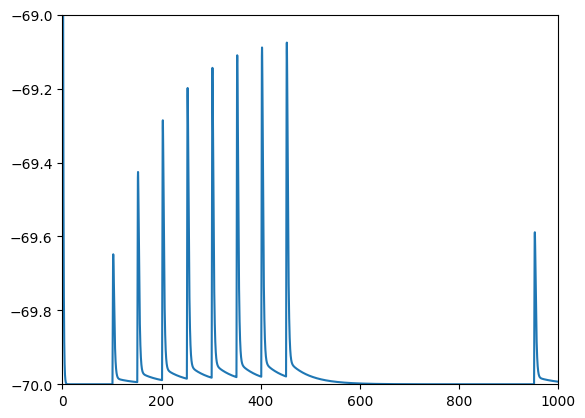

In [10]:
# plot how the post-synaptic EPSPs look like 
plt.figure()
plt.plot(time, v_soma)
plt.axis([0, 1000, -70, -69.0])

<font size = "3">Let's see how the fraction of available resources (R) and the Use of resources as well as
the conductivity (g) behave during the stimulation

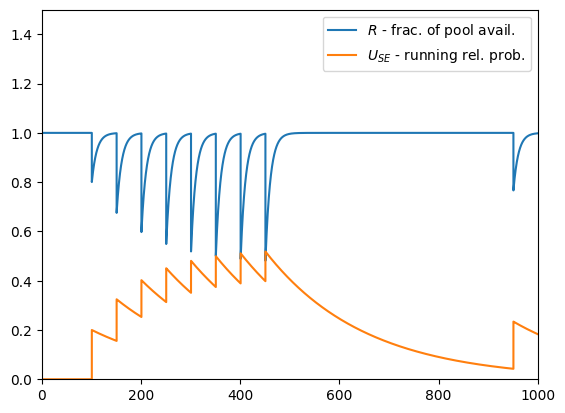

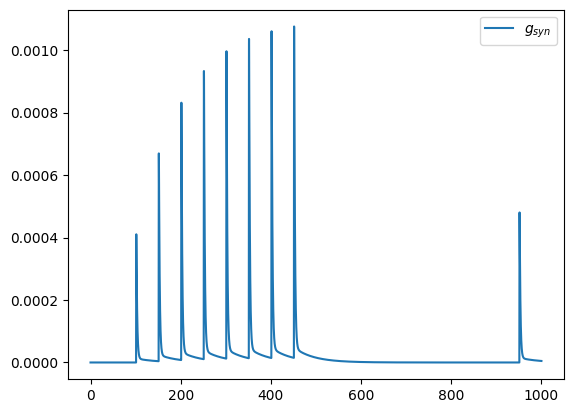

In [11]:
plt.figure()
plt.plot(time, R_syn, label="$R$ - frac. of pool avail.")
plt.plot(time, Use_syn, label="$U_{SE}$ - running rel. prob.")
plt.legend()
plt.axis([0, 1000, 0, 1.5])

plt.figure()
plt.plot(time, g_syn, label="$g_{syn}$")
plt.legend()

## 2. Real neurons forming synapses.

### Depressing synapse: E2
(according to [Markarm et al., 1997](https://www.pnas.org/doi/10.1073/pnas.94.2.719))

<font size='3'>Now, let's configure a depressing synapse (E2) connecting two real morphologies.  E2 type synapses have a higher baseline release probability (U1), a longer recovery time from depression (tau_rec), and a very short relaxation time of facilitation (tau_facil). This means that the synapse runs out of vesicles fairly quickly and the probability of releasing vesicles increases for only a short time.

The parameters in "TsodyksMarkram_AMPA_NMDA.mod" default to this kind of synapse
    
*Slides: 40 - 49 of week8 lecture

### 2.1 Define a Cell class and instanciate the real morphologies 

In [12]:
# First, we have to define Cell class with specific channel behavior

class Cell:
    def __init__(self, filename, name, cell_type):
        self.name = name
        self.type = cell_type
        self.synapses = []
        self.build_morphology(filename)
        self.biophysics()
        
    def build_morphology(self, filename):
        """
        Loads a 3D morphology of the neuron
        """
        h.load_file("import3d.hoc")
        h.load_file("stdlib.hoc")
        morph_reader = h.Import3d_Neurolucida3()
        #morph_reader = h.Import3d_SWC_read()
        morph_reader.input(filename)
        i3d = h.Import3d_GUI(morph_reader, 0)
        i3d.instantiate(self)  # Notice this change to be able to instantiate several cells

        # Create python lists from the morphology with the different sections: soma, dend, apic and axon
        self.somatic = []
        self.basal = []
        self.apical = []
        #self.axonal = [] # for the moment we will forget about the axon
        self.all = []
        for sec in h.allsec():
            #print (sec)
            if 'soma' in sec.name():
                self.somatic.append(sec)
            if 'dend' in sec.name():
                self.basal.append(sec)
            if 'apic' in sec.name():
                self.apical.append(sec)
            #if 'axon' in sec.name():
            #    self.axonal.append(sec)
    
    def biophysics(self):
        """
        Distributes passive mechanisms and the different types
        of ion channels on the soma and dendrites
        """
        # Define passive properties
        # You can try to change the passice properties and see what happens
        for sec in h.allsec():
            sec.Ra = 100
            sec.cm = 1
            sec.insert("pas")
            for seg in sec:
                seg.pas.g = 0.00003
                seg.pas.e = -75
                
        # Define active properties for soma and dendrites (basal and apical)
        for sec in self.somatic:
            sec.insert('NaTs2_t')
            for seg in sec:
                seg.gNaTs2_tbar_NaTs2_t = 0.25 
            sec.insert('SK_E2')
            for seg in sec:
                seg.gSK_E2bar_SK_E2 = 0.01
            sec.insert('SKv3_1') 
            for seg in sec:
                seg.gSKv3_1bar_SKv3_1 = 0.1
          
        for sec in self.apical:
            sec.insert('NaTs2_t')
            for seg in sec:
                seg.gNaTs2_tbar_NaTs2_t = 0.25 
            sec.insert('SK_E2')
            for seg in sec:
                seg.gSK_E2bar_SK_E2 = 0.01
            sec.insert('SKv3_1') 
            for seg in sec:
                seg.gSKv3_1bar_SKv3_1 = 0.1
        
        for sec in self.basal:
            sec.insert('NaTs2_t')
            for seg in sec:
                seg.gNaTs2_tbar_NaTs2_t = 0.25 
            sec.insert('SK_E2')
            for seg in sec:
                seg.gSK_E2bar_SK_E2 = 0.01
            sec.insert('SKv3_1') 
            for seg in sec:
                seg.gSKv3_1bar_SKv3_1 = 0.1

In [13]:
# Second, we can instantiate the Cells that we will use for the simulation.

path_pyr1 = "morphologies/dend-C261296A-P1_axon-C060114A4_-_Scale_x1.000_y0.975_z1.000.asc"
path_pyr2 = "morphologies/dend-vd111221_idB_axon-vd110330_idB_-_Scale_x1.000_y1.050_z1.000.asc"

Pyr1 = Cell(path_pyr1, "Pyr1", "Pyr")
Pyr2 = Cell(path_pyr2, "Pyr2", "Pyr")

NEURON: morphologies/dend-C261296A-P1_axon-C060114A4_-_Scale_x1.000_y0.975_z1.000.asc :file is not open
 near line 0
 ^
        File[0].eof()
      Import3d_Neurolucida3[0].rdfile("morphologi...")
    Import3d_Neurolucida3[0].input("morphologi...")


could not open morphologies/dend-C261296A-P1_axon-C060114A4_-_Scale_x1.000_y0.975_z1.000.asc


RuntimeError: hocobj_call error

In [14]:
# Just for curiosity, let's check which sections formed these cells.

cells_Pyr = [Pyr1, Pyr2]

for c in cells_Pyr:
    print(
        "%s: %d apical sections, %d basal sections, %d soma sections and %d axon sections"
        % (c.name, len(c.apic), len(c.dend), len(c.soma), len(c.axon))
    )

NameError: name 'Pyr1' is not defined

### 2.2 Connect the cells 
The connect function establishes a synapse between a random neurite on the source cell, and a random dendrite on the target cell.

In [15]:
# Third, we can connect the two cells with an TM synapse at given locations
# This function returns the netcon

def connect(
    source,
    target,
    weight=None,
    delay=5,
    source_sec=None,
    source_neurite="axon",
    target_sec=None,
    target_neurite="dend",
    ):
    rng = np.random.default_rng()

    if weight is None:
        weight = rng.uniform()  # random weight

    target_neurite_ = getattr(target, target_neurite)
    if target_sec is None:
        target_sec = rng.integers(0, len(target_neurite_))  # random dendritic section

    source_neurite_ = getattr(source, source_neurite)
    if source_sec is None:
        source_sec = rng.integers(0, len(source_neurite_))  # random axonal section
    
    # HERE WE INTRODUCE THE SYNAPTIC MECHANISM !!!!!!!
    target_syn = h.TsodyksMarkram_AMPA_NMDA(target_neurite_[target_sec](0.5))
    target_syn.gmax_AMPA = 0.002  # uS
    target_syn.gmax_NMDA = (0.7 * 0.002)  # uS 0.7 is a biologically typical ratio of NMDA to AMPA conductance
    target.synapses.append(target_syn)  # store synapse

    netcon = h.NetCon(
        source_neurite_[source_sec](0.5)._ref_v,
        target_syn,
        sec=source_neurite_[source_sec],
    )
    netcon.weight[0] = weight

    print(
        f"Connected cells {source.name} -> {target.name} with weight {weight} and delay {delay}, from {source_neurite}[{source_sec}] to {target_neurite}[{target_sec}]"
    )

    return netcon

In [16]:
# Now we connect Pyr1 to Pyr2 by executing the previous function
# We create 5 randomly connected dendo-dendritic connections
# yes, most synapses usually form axon-to-dendrite, but dendro-dendritic synapses exist as well.

nc1 = connect(Pyr1, Pyr2, weight=1.0, source_neurite = "dend")
nc2 = connect(Pyr1, Pyr2, weight=1.0, source_neurite = "dend")
nc3 = connect(Pyr1, Pyr2, weight=1.0, source_neurite = "dend")
nc4 = connect(Pyr1, Pyr2, weight=1.0, source_neurite = "dend")
nc5 = connect(Pyr1, Pyr2, weight=1.0, source_neurite = "dend")

NameError: name 'Pyr1' is not defined

### 2.3. Run the simulation

In [17]:
# first we create a stimulation vector with the times of the stimulation.
stimulator = h.VecStim()
spike_times = [100.0, 150.0, 200.0, 250.0, 300.0, 350.0, 400.0, 450.0, 950.0] # ms
spikes_vector = h.Vector(spike_times)
stimulator.play(spikes_vector)

# We want to stimulate the pre-cell and see the effet on the post-cell.
# For this we add an exponential synapse (h.ExpSyn mechanism) stimulating the soma of the pre-cell
# There are different mechanisms that you can use for that, like h.IClamp.
stim_place1 = h.ExpSyn(Pyr1.soma[0](0.5))
stim_place1.tau = 2  # ms

# Add stimulator to synapses
connection1 = h.NetCon(stimulator, stim_place1)
connection1.weight[0] = 0.5  # In units of [nS] due to the gmax scaling factor in our .mod file

NameError: name 'Pyr1' is not defined

In [18]:
# record voltage at pre and post-cell somas and plot them
soma_v1 = h.Vector().record(Pyr1.soma[0](0.5)._ref_v)
soma_v2 = h.Vector().record(Pyr2.soma[0](0.5)._ref_v)

#record time
time = h.Vector().record(h._ref_t)

# run simulation
h.finitialize(-65)
h.continuerun(1200)

NameError: name 'Pyr1' is not defined

In [19]:
# Plot pre and post-cells voltage traces
plt.figure(figsize=(15, 5))
plt.plot(time, soma_v1, label="pre", color="blue")
plt.plot(time, soma_v2, label="post", color="red")
plt.legend()
plt.show()

NameError: name 'soma_v1' is not defined

<Figure size 1500x500 with 0 Axes>

In [20]:
# Plot only post-cell voltage trace
time_arr = np.array(time)
soma_v2_arr = np.array(soma_v2)

print(time_arr.shape)

plt.figure(figsize=(15, 5))
plt.plot(time_arr[4000:], soma_v2_arr[4000:], label="post", color="red")
plt.legend()
plt.show()

NameError: name 'soma_v2' is not defined